In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from wordcloud import WordCloud
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

file1 (한강수_reviews_추천순.csv): 컬럼명은 Index, Date, Review
file2 (hangangsu_reviews_kakao.csv): 컬럼명은 작성 날짜, 리뷰 내용
file3 (hangangsu_reviews_google.csv): 컬럼명은 ID, Date, Review

In [ ]:
data = pd.read_csv('./data/한강수_reviews_추천순.csv')
data2 = pd.read_csv('./data/hangangsu_reviews_kakao.csv')
data3 = pd.read_csv('./data/hangangsu_reviews_google.csv')

1. 데이터 전처리

In [13]:
import pandas as pd
import re
from datetime import datetime, timedelta

# 파일 경로 설정
file1 = './data/한강수_reviews_추천순.csv'
file2 = './data/hangangsu_reviews_kakao.csv'
file3 = './data/hangangsu_reviews_google.csv'

# 파일 읽기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# 컬럼명 통일 및 불필요한 컬럼 제거
df1 = df1.rename(columns={"Date": "Date", "Review": "Review"}).drop(columns=["Index"], errors='ignore')
df2 = df2.rename(columns={"작성 날짜": "Date", "리뷰 내용": "Review"})
df3 = df3.rename(columns={"ID": "ID", "Date": "Date", "Review": "Review"}).drop(columns=["ID"], errors='ignore')

# 각 데이터프레임에서 날짜 형식 통일
# 1. df1은 '년 월 일 요일' 형식이므로 '년 월 일' 부분만 추출하여 변환
df1['Date'] = df1['Date'].str.extract(r'(\d{4}년 \d{1,2}월 \d{1,2}일)')[0]
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y년 %m월 %d일', errors='coerce')

# 2. df2는 'YYYY.MM.DD.' 형식으로 날짜 변환
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y.%m.%d.', errors='coerce')

# 3. df3은 상대적 날짜 표현을 현재 날짜 기준으로 변환
def convert_relative_date(date_str):
    if '년 전' in date_str:
        years_ago = int(re.search(r'(\d+)년 전', date_str).group(1))
        return datetime.now() - timedelta(days=years_ago * 365)
    elif '달 전' in date_str:
        months_ago = int(re.search(r'(\d+)달 전', date_str).group(1))
        return datetime.now() - timedelta(days=months_ago * 30)
    elif '일 전' in date_str:
        days_ago = int(re.search(r'(\d+)일 전', date_str).group(1))
        return datetime.now() - timedelta(days=days_ago)
    return None

df3['Date'] = df3['Date'].apply(lambda x: convert_relative_date(x) if isinstance(x, str) else None)

# 데이터 병합
df_combined = pd.concat([df1, df2, df3], ignore_index=True)

# 병합 후 데이터 확인
print("병합된 데이터 개수:", len(df_combined))
print("병합된 데이터 미리보기:", df_combined.head())

# 중복 제거 (리뷰 내용 기준으로 중복 제거)
df_combined = df_combined.drop_duplicates(subset=["Review"]).reset_index(drop=True)

# 최종 데이터 확인
print("최종 데이터 개수:", len(df_combined))
print("최종 데이터 미리보기:", df_combined.head())


병합된 데이터 개수: 143
병합된 데이터 미리보기:         Date                                             Review
0 2024-10-08      동네 친구들이랑 한잔하러 왔어요\n주차하기 편하고 고기 질 좋고 가성비 좋아요😊😊
1 2024-07-31  강남 뱅뱅매장 뒤편에 위치해있습미당~\n고기집으로 퀄리티가 좋고 맛도 좋아용\n점심...
2 2024-10-12           모두 친철하시고, 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요~👍🏻
3 2024-10-29                                                  굿
4 2024-09-06                                                  굿
최종 데이터 개수: 110
최종 데이터 미리보기:         Date                                             Review
0 2024-10-08      동네 친구들이랑 한잔하러 왔어요\n주차하기 편하고 고기 질 좋고 가성비 좋아요😊😊
1 2024-07-31  강남 뱅뱅매장 뒤편에 위치해있습미당~\n고기집으로 퀄리티가 좋고 맛도 좋아용\n점심...
2 2024-10-12           모두 친철하시고, 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요~👍🏻
3 2024-10-29                                                  굿
4 2024-07-03                          맛있게 먹었습니다~~~점심때도 손님이 많아요ㅋ


In [16]:
import re
import pandas as pd

# 특수 문자 제거 함수 수정: '\n'과 '#' 등 특수 문자 제거
def clean_special_characters(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))
    return text  # NaN 또는 비문자열은 그대로 반환

# 새로운 불용어 리스트 정의
stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름"
]

# 불용어 제거 함수 정의
def remove_stopwords(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        return ' '.join([word for word in text.split() if word not in stopwords])
    return text  # NaN 또는 비문자열은 그대로 반환


# 특수 문자 제거 및 불용어 제거 적용
df_combined['Cleaned_Review'] = df_combined['Review'].apply(clean_special_characters)
df_combined['No_Stopwords_Review'] = df_combined['Cleaned_Review'].apply(remove_stopwords)

# 결과 확인
print(df_combined[['Cleaned_Review', 'No_Stopwords_Review']].head())


                                      Cleaned_Review  \
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요   
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...   
2               모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요   
3                                                  굿   
4                              맛있게 먹었습니다점심때도 손님이 많아요   

                                 No_Stopwords_Review  
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요  
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...  
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요  
3                                                  굿  
4                              맛있게 먹었습니다점심때도 손님이 많아요  


In [17]:
from konlpy.tag import Mecab

# Mecab 형태소 분석기 설정
mecab = Mecab()

# 명사 추출 함수 정의
def extract_nouns(text):
    if isinstance(text, str):  # 문자열인 경우에만 처리
        return ' '.join(mecab.nouns(text))
    return text  # NaN 또는 비문자열은 그대로 반환

# 명사 추출 적용
df_combined['Nouns_Review'] = df_combined['No_Stopwords_Review'].apply(extract_nouns)

# 결과 확인
print(df_combined[['No_Stopwords_Review', 'Nouns_Review']].head())


                                 No_Stopwords_Review  \
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요   
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...   
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요   
3                                                  굿   
4                              맛있게 먹었습니다점심때도 손님이 많아요   

                                        Nouns_Review  
0                                  동네 친구 한잔 주차 고기 성비  
1  강남 뒤편 위치 미당 고기 집 퀄리티 맛 점심 메뉴 회덮밥 최애 메뉴 양 점심 시간...  
2                                      철 고기 반찬 하나 하나  
3                                                  굿  
4                                              점심때 손  


In [18]:
from collections import Counter

# Nouns_Review 컬럼의 모든 단어를 리스트로 합치기
all_nouns = ' '.join(df_combined['Nouns_Review'].dropna()).split()

# 단어 빈도 계산
word_counts = Counter(all_nouns)

# 상위 20개의 자주 언급된 단어 출력
print(word_counts.most_common(50))

[('고기', 40), ('친절', 17), ('점심', 13), ('반찬', 12), ('집', 11), ('맛', 11), ('한우', 10), ('육회', 10), ('사장', 10), ('최고', 10), ('메뉴', 9), ('성비', 7), ('굿', 7), ('비빔밥', 7), ('밑반찬', 7), ('거', 7), ('양', 6), ('직원', 6), ('가성', 6), ('게', 6), ('가격', 6), ('갈비', 6), ('퀄리티', 5), ('소고기', 5), ('음식', 5), ('편', 5), ('살치', 5), ('서비스', 5), ('다음', 5), ('질', 5), ('식사', 5), ('등심', 5), ('비', 5), ('주차', 4), ('강남', 4), ('맛집', 4), ('때', 4), ('영양', 4), ('새우', 4), ('기분', 4), ('데', 4), ('분', 4), ('육', 4), ('사시미', 4), ('곳', 4), ('정도', 4), ('인분', 4), ('김치', 4), ('하나', 3), ('손', 3)]


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# CountVectorizer로 벡터화 (자주 등장하는 단어 위주로 제한하여 최적화)
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df_combined['Nouns_Review'].dropna())

# LDA 모델 설정 및 학습 (5개의 주제를 추출하도록 설정)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# 토픽별 주요 단어 출력
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}: ", [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])


Topic 1:  ['고기', '기분', '갈비', '인분', '친절', '신경', '식사', '소고기', '가격', '서비스']
Topic 2:  ['고기', '최고', '점심', '반찬', '메뉴', '성비', '퀄리티', '갈비탕', '식당', '하나']
Topic 3:  ['육회', '가성', '비빔밥', '점심', '맛집', '영양', '밑반찬', '서비스', '성비', '근처']
Topic 4:  ['친절', '한우', '사장', '직원', '김치', '살치', '음식', '등심', '반찬', '정도']
Topic 5:  ['새우', '메뉴판', '무엇', '고기', '메뉴', '소고기', '살치', '한우', '암소', '인분']


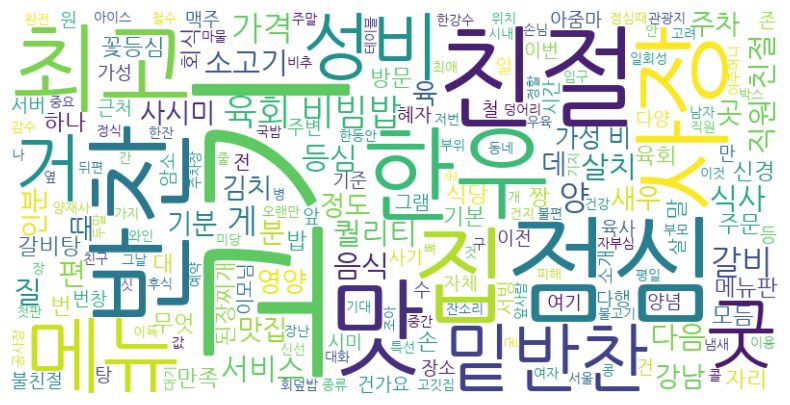

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 'NanumGothic' 폰트가 설치되어 있어야 함

# 워드 클라우드 생성
text_for_wordcloud = ' '.join(df_combined['Nouns_Review'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(text_for_wordcloud)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


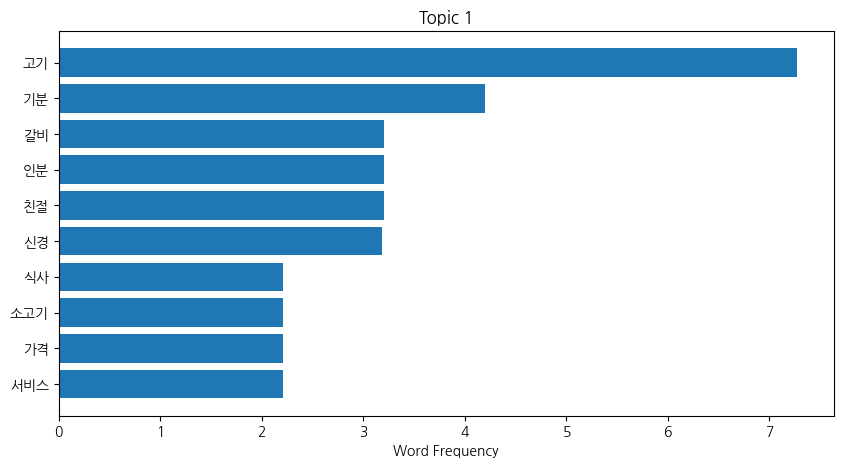

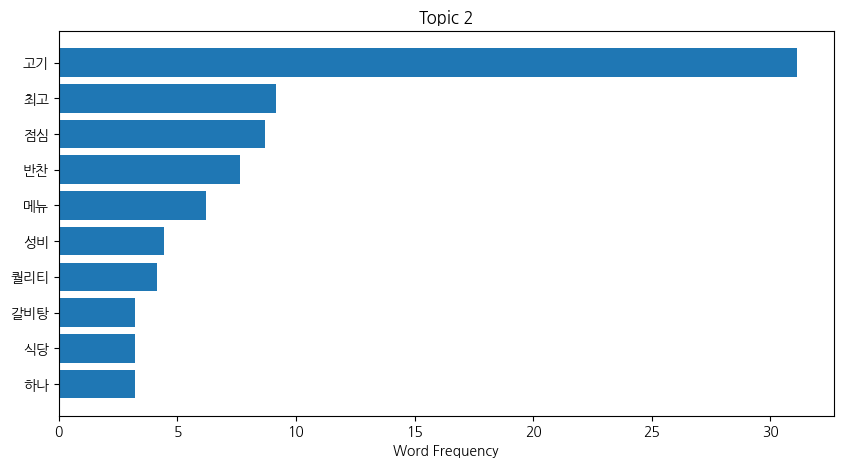

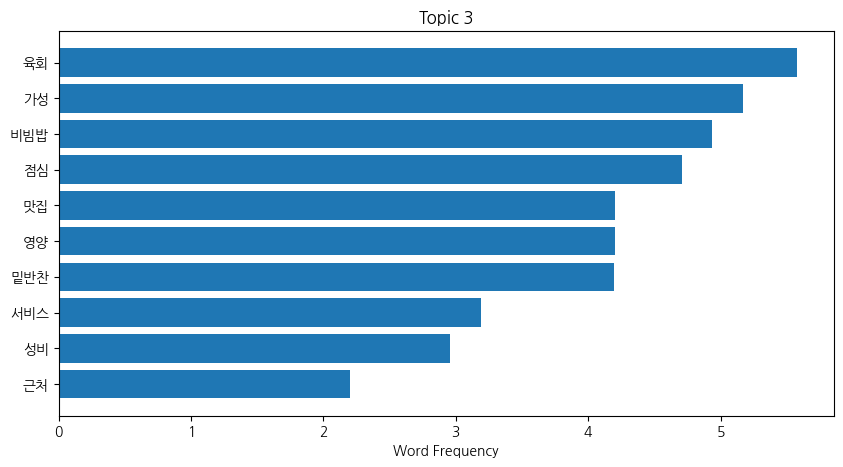

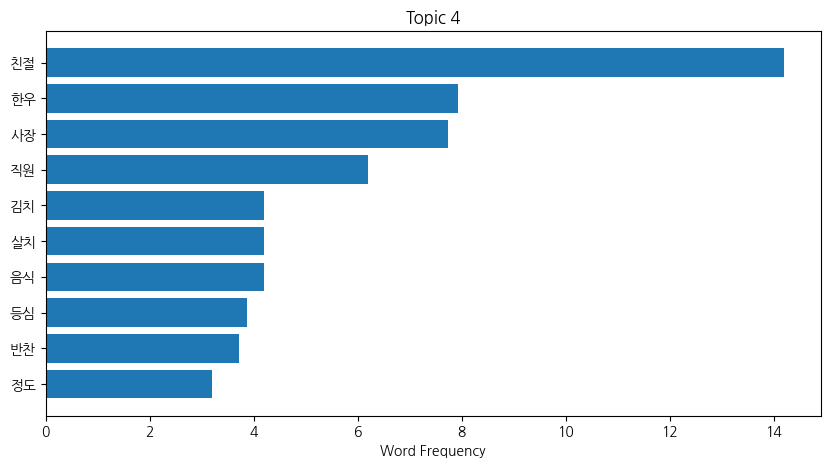

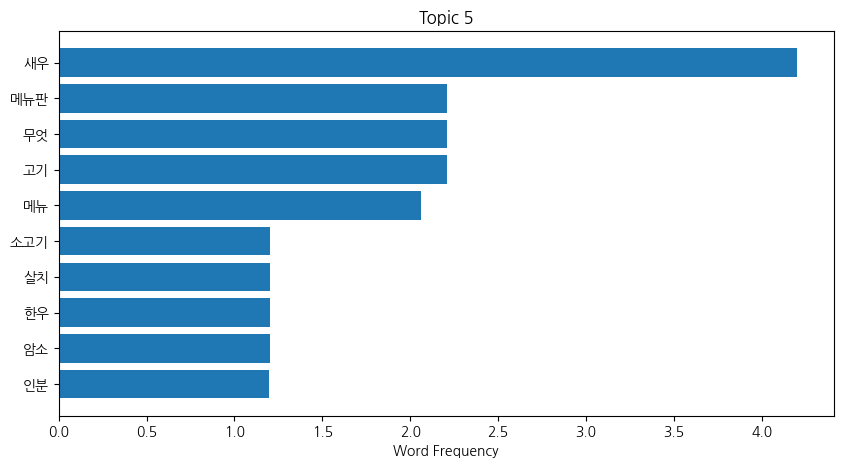

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 'NanumGothic' 폰트가 설치되어 있어야 합니다.

# 각 주제별로 주요 단어와 빈도를 막대 그래프로 시각화
num_top_words = 10  # 각 주제에서 상위 10개 단어를 시각화
topics = []

for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_word_counts = topic[topic.argsort()[:-num_top_words - 1:-1]]
    topics.append((f"Topic {topic_idx + 1}", top_words, top_word_counts))

# 각 토픽에 대해 막대 그래프 그리기
for topic in topics:
    topic_name, words, counts = topic
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts)
    plt.gca().invert_yaxis()  # 단어가 위에서부터 아래로 정렬되도록
    plt.title(topic_name)
    plt.xlabel("Word Frequency")
    plt.show()


In [24]:
import streamlit as st
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from konlpy.tag import Mecab

# 기본 설정
st.title("리뷰 데이터 분석")
st.write("이 애플리케이션은 리뷰 데이터를 분석하여 단어 빈도와 주제를 시각화합니다.")

# 데이터 업로드
uploaded_file = st.file_uploader("CSV 파일 업로드", type="csv")
if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    
    # 리뷰 데이터 전처리
    st.subheader("데이터 전처리")
    st.write("불용어 제거 및 형태소 분석을 통해 명사만 추출합니다.")
    
    # Mecab 설정 및 명사 추출 함수
    mecab = Mecab()
    def extract_nouns(text):
        if isinstance(text, str):
            return ' '.join(mecab.nouns(text))
        return text
    
    # 리뷰 데이터 전처리 적용
    df['Nouns_Review'] = df['Review'].apply(extract_nouns)
    st.write("전처리된 데이터:")
    st.dataframe(df[['Review', 'Nouns_Review']].head())

    # 단어 빈도 분석
    st.subheader("단어 빈도 분석")
    all_nouns = ' '.join(df['Nouns_Review'].dropna()).split()
    word_counts = Counter(all_nouns)
    top_20_words = word_counts.most_common(20)
    st.write("상위 20개의 자주 언급된 단어:")
    st.write(top_20_words)

    # 워드 클라우드 생성
    st.subheader("워드 클라우드")
    text_for_wordcloud = ' '.join(df['Nouns_Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(text_for_wordcloud)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    st.pyplot(plt)

    # LDA 주제 모델링
    st.subheader("주제 모델링 (LDA)")
    vectorizer = CountVectorizer(max_df=0.9, min_df=2)
    X = vectorizer.fit_transform(df['Nouns_Review'].dropna())

    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    lda_model.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    num_top_words = 10

    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append((f"Topic {topic_idx + 1}", top_words))
    
    for topic_name, words in topics:
        st.write(f"{topic_name}: {', '.join(words)}")

    # 토픽별 막대 그래프
    st.subheader("토픽별 주요 단어 빈도 막대 그래프")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        top_word_counts = topic[topic.argsort()[:-num_top_words - 1:-1]]

        plt.figure(figsize=(10, 5))
        plt.barh(top_words, top_word_counts)
        plt.gca().invert_yaxis()
        plt.title(f"Topic {topic_idx + 1}")
        plt.xlabel("Word Frequency")
        st.pyplot(plt)


ModuleNotFoundError: No module named 'streamlit'

In [25]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 57.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 8.4 MB/s eta 0:00:00ta 0:00:01


In [26]:
code = """
import streamlit as st
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from konlpy.tag import Mecab

# 기본 설정
st.title("리뷰 데이터 분석")
st.write("이 애플리케이션은 리뷰 데이터를 분석하여 단어 빈도와 주제를 시각화합니다.")

# 데이터 업로드
uploaded_file = st.file_uploader("CSV 파일 업로드", type="csv")
if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    
    # 리뷰 데이터 전처리
    st.subheader("데이터 전처리")
    st.write("불용어 제거 및 형태소 분석을 통해 명사만 추출합니다.")
    
    # Mecab 설정 및 명사 추출 함수
    mecab = Mecab()
    def extract_nouns(text):
        if isinstance(text, str):
            return ' '.join(mecab.nouns(text))
        return text
    
    # 리뷰 데이터 전처리 적용
    df['Nouns_Review'] = df['Review'].apply(extract_nouns)
    st.write("전처리된 데이터:")
    st.dataframe(df[['Review', 'Nouns_Review']].head())

    # 단어 빈도 분석
    st.subheader("단어 빈도 분석")
    all_nouns = ' '.join(df['Nouns_Review'].dropna()).split()
    word_counts = Counter(all_nouns)
    top_20_words = word_counts.most_common(20)
    st.write("상위 20개의 자주 언급된 단어:")
    st.write(top_20_words)

    # 워드 클라우드 생성
    st.subheader("워드 클라우드")
    text_for_wordcloud = ' '.join(df['Nouns_Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(text_for_wordcloud)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    st.pyplot(plt)

    # LDA 주제 모델링
    st.subheader("주제 모델링 (LDA)")
    vectorizer = CountVectorizer(max_df=0.9, min_df=2)
    X = vectorizer.fit_transform(df['Nouns_Review'].dropna())

    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    lda_model.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    num_top_words = 10

    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append((f"Topic {topic_idx + 1}", top_words))
    
    for topic_name, words in topics:
        st.write(f"{topic_name}: {', '.join(words)}")

    # 토픽별 막대 그래프
    st.subheader("토픽별 주요 단어 빈도 막대 그래프")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        top_word_counts = topic[topic.argsort()[:-num_top_words - 1:-1]]

        plt.figure(figsize=(10, 5))
        plt.barh(top_words, top_word_counts)
        plt.gca().invert_yaxis()
        plt.title(f"Topic {topic_idx + 1}")
        plt.xlabel("Word Frequency")
        st.pyplot(plt)

"""
with open("app.py", "w") as file:
    file.write(code)


2. 감성 분석

In [5]:
# 감성 단어 리스트 설정
positive_words = ["좋다", "좋고", "훌륭", "최고", "맛있", "추천", "즐겁", "기쁘", "만족", "감동", "깨끗", "재밌", "친절",
    "감사", "좋아하", "편안", "행복", "깔끔", "존맛", "JMT", "맛집", "짱", "베스트", "대박",
    "최애", "힐링", "감탄", "인생", "역대급", "완벽", "신선", "든든", "엄지 척", "배려", "뿌듯",
    "포근", "추천템", "안심", "만족도 최고", "편리", "세련", "유용", "아늑", "기대 이상", "고급지다",
    "센스있", "특별", "화려", "러블리", "맛보장", "행운", "예쁘다", "베리 굿", "가성비 좋", "적극 추천",
    "감성적", "취향저격", "레전드", "완소", "쏘 스윗", "찐행복", "갓성비", "귀엽", "최애템", "핵꿀잼",
    "고급미", "갓벽", "미쳤다", "오져", "대만족", "찐사랑", "신박", "고퀄", "강추", "존좋", "너무 좋",
    "죽인다", "굿굿", "금손", "소확행", "최상급", "훈훈", "신세계", "고급짐", "재구매 의사", "초강추",
    "귀엽고 예쁨", "찐템", "꿀템", "신박하다", "행복함", "안심됨", "극호", "꾸안꾸", "손맛 좋",
    "핵감동", "친근감", "든든함", "사랑스러움", "행복사", "찐최애", "만점템", "찐인생템", "눈호강",
    "청정구역", "맑고 깨끗", "깨알재미", "귀염", "사랑스럽다", "가성비템", "깔쌈", "베리굿", "딱 좋음",
    "잘 나감", "편의성 굿", "안정적", "배부름", "센스 만점", "짱짱맨", "적극적", "말해 뭐해", "넘사벽",
    "신뢰감", "꿀잼보장", "심쿵", "센스 넘침", "재미짐", "편리함", "만족스러움", "무한 감동", "탄탄함",
    "우수함", "굿", "존맛탱구리", "ㄴㅇㅅ", "내돈내산", "또방문", "재방문 의사 있", "유명", "소문낼",
    "유명한 이유가 있", "돈 값을 하는", "충족", "ㄱㅇㄷ", "개이득", "최상", "킹왕짱", "행복함",
    "맛집 인정", "찐맛", "호불호 없음", "득템각", "부담없", "소장각", "갓템", "마음에 쏙", "신뢰성",
    "마음에 든다", "완소템", "힐링템", "푹신함", "대존맛", "신의 한 수", "필수템", "사길 잘함", "극찬",
    "알차다", "취향존중", "무조건 추천", "고급", "실속 있음", "잘 맞음", "너무 예쁘다",
    "만족함", "매력있음", "비교불가", "퀄리티 갑", "최상의 선택", "역시 좋다", "손이 가요",
    "가치 있음", "핫플", "핵추천", "혜자템", "품질보장", "끝내줌", "강력 추천", "금방 동남",
    "엄지척", "거의 완벽", "찬사받음", "너무 예쁨", "감동적", "눈이 즐거움", "존맛", "핫템",
    "정말 좋아요", "불만 없음", "깔끔한 마무리", "퀄리티 짱", "세상 최고", "매력적", "끝내줌", "눈물남",
    "현존 최고", "좋은 선택", "짱짱", "상상초월", "미친 가성비", "저렴한데 좋음", "찐", "돈 값함",
    "인정", "핵만족", "보장된 품질", "칭찬할 만함", "행운템", "아기자기함", "다시 가고 싶음",
    "핵감사", "짱짱짱", "여긴 진짜다"]
negative_words = ["나쁘", "별로", "싫", "최악", "불편", "문제", "실망", "불만", "안좋", "안되", "부족", "힘들",
    "비싸", "짜증", "불친절", "후회", "아쉽", "형편없", "엉망", "답답", "지루", "불쾌", "피곤",
    "귀찮", "못하", "어렵", "복잡", "짜증나", "실수", "기대 이하", "아깝", "화나", "무례", "미흡",
    "고통", "시끄럽", "안타깝", "낡", "지저분", "아프", "헛걸음", "속상", "똥손", "후지", "망",
    "버거움", "별로임", "바가지", "낙후", "불량", "헛돈", "극혐", "잦은 오류", "대충", "불쾌한 경험",
    "비추", "별로네", "허접", "노답", "구려", "폐급", "구리다", "짜증 폭발", "돈낭비", "헬", "멘붕",
    "분노", "허접하다", "불편함", "답답함", "현타", "먹튀", "짜증남", "신경쓰임", "헛돈", "개노답",
    "한심", "쌩돈", "쓰레기", "이딴", "어설프다", "오류 많음", "형편없음", "허무함", "낭비", "아쉬움",
    "개판", "헬게이트", "어이없음", "대실망", "구림", "후회막급", "서비스 엉망", "좌절", "불편하다",
    "무리수", "취소각", "짜증만땅", "불만족", "더럽다", "화가남", "찝찝", "바가지", "속터짐", "별로다",
    "실망스러움", "별로에요", "스트레스", "무책임", "노잼", "먹금", "못난", "오바임", "과대광고",
    "구라", "실망임", "불만족스럽", "개노답", "망했", "못하겠", "허접쓰", "오지랖", "지저분함",
    "헛소리", "오류투성이", "피곤함", "서비스 엉망진창", "예민함", "낙제점", "답없다", "과함", "잔소리",
    "번거로움", "불완전", "뻘짓", "정떨어짐", "영혼 없음", "허술함", "제자리", "정리안됨", "답이 없음",
    "빈약함", "불친절한 응대", "뻔뻔", "낙후됨", "어이상실", "시간낭비", "멀미", "부실함", "막장임",
    "헛고생", "최악의 경험", "실망감", "엉망진창", "걱정됨", "재방문 의사 없", "개노맛", "실망각",
    "차라리 안 샀음", "먹다 버림", "재구매 없음", "헛돈 날림", "버림", "답답함", "후회함", "개망",
    "터무니없", "형편 없음", "망템", "퀄리티 떨어짐", "돈 아까움", "상태 불량", "비효율적", "쓸모없음",
    "버림", "품질 저하", "오바스러움", "가성비 별로", "마음에 안 듦", "손해", "완전 별로", "무의미",
    "효율성 없음", "가치 없음", "엉성함", "재방문 안함", "비추함", "믿고 걸러", "두 번 다시", "안 맞음",
    "어이없다", "구매 비추천", "완전 구림", "불량품", "기대와 다름", "불쾌감", "미스", "절대 비추",
    "낭비된 돈", "비추요", "이 돈값 못함", "바로 반품", "싼 게 비지떡", "텅텅", "돈값 못함", "손해봤다",
    "별로였음", "너무 별로", "비추템", "핵노잼", "돈 아까움", "실망", "안간다", "차라리 딴데", "속았음",
    "후회만 남음", "맘 상함", "믿거템", "한 번 가고 안 감", "사기템", "버림", "쓰레기템", "더러움",
    "터무니 없음", "낚임", "두 번은 안 감", "쓰레기 서비스", "불안함", "서비스 미숙", "당황스러움",
    "너무 느림", "후회만 가득", "갈 이유 없음", "마음 상함", "말도 안 됨", "너무 허접", "없어서 못감",
    "체감상 별로", "기분 상함", "하자 많음", "최악의 결정", "구매 후회", "안습", "저렴한 티", "헛된 시간",
    "망함", "지저분", "두 번 안 감", "손해봄", "싼 맛에 샀는데 후회", "기대보다 별로", "차라리 안 사는 게",
    "기분 상함", "아무것도 아님", "안 사는 게 나음", "갓성비 아님", "여기만 빼고 다 좋음", "진절머리",
    "진저리", "별로다 못해 최악", "위생이 별로"]

# 감성 분석 함수
def analyze_sentiment(review):
    review_lower = review.lower()
    pos_count = sum(word in review_lower for word in positive_words)
    neg_count = sum(word in review_lower for word in negative_words)
    if pos_count > neg_count:
        return "Positive"
    elif neg_count > pos_count:
        return "Negative"
    else:
        return "Neutral"

# 감성 분석 적용
df_combined["Sentiment"] = df_combined["Review"].apply(analyze_sentiment)


3. 주요 주제 추출 (LDA 토픽 모델링)

In [12]:
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Mecab 형태소 분석기 설정
mecab = Mecab()

# 리뷰에서 명사만 추출하여 새로운 텍스트 데이터 생성
df_combined["Processed_Review"] = df_combined["Review"].apply(lambda x: " ".join(mecab.nouns(x)) if x else "")

# Processed_Review가 비어 있는지 다시 확인
print("Processed_Review Preview:", df_combined["Processed_Review"].head())

# 빈 문자열 제거
df_combined = df_combined[df_combined["Processed_Review"].str.strip() != ""]
df_combined = df_combined.dropna(subset=["Processed_Review"]).reset_index(drop=True)

# 벡터화 설정
vectorizer = CountVectorizer(max_df=0.9, min_df=1)
review_matrix = vectorizer.fit_transform(df_combined["Processed_Review"])

# LDA 모델 설정 및 학습
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topics = lda_model.fit_transform(review_matrix)

# 토픽별 주요 단어 추출
num_top_words = 10
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}: ", [words[i] for i in topic.argsort()[-num_top_words:]])


Processed_Review Preview: Series([], Name: Processed_Review, dtype: object)


ValueError: empty vocabulary; perhaps the documents only contain stop words

4. 유사 리뷰 군집화 (KMeans)

In [ ]:
from sklearn.cluster import KMeans

# KMeans 클러스터링
num_clusters = 3
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans_model.fit_predict(lda_topics)

# 클러스터 레이블 추가
df_combined["Cluster"] = kmeans_labels


5. 워드 클라우드 생성

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 모든 리뷰 텍스트 결합
all_reviews_text = " ".join(df_combined["Review"].astype(str))

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, collocations=False).generate(all_reviews_text)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Review Keywords")
plt.show()
